# **Nombre:** Julio Muñoz P.

#Detección de rostros y landmarks

La detección y reconocimiento de rostros es una de las tareas más populares, investigadas, y controlversiales de la visión por computación. Estos problemas han ayudado a impulsar el campo en varias direcciones. Algunas aplicaciones interesantes incluyen la vigilancia, el desbloqueo de dispositivos por datos biométricos, análisis de sentimientos, e incluso entretenimiento. <br>
En esta oportunidad vamos a repasar algunas herramientas existentes, partiendo desde las más fáciles de instalar hasta algunas más potentes. Aunque primero vamos a descargar algo de material para trabajar.<br>


In [ ]:
!gdown --id 1T3LHiHgB4BG6oZr5G6ePck-M3on3HTNz
!unzip face_material.zip

<H3>Face Recognition</H3>
Este es un paquete de aplicaciones de python antiguo. Tan fácil de utilizar como de instalar. 

In [ ]:
!pip install face_recognition

Hagamos una prueba, carga la imagen con nombre "students-1807505_640.jpg"

In [ ]:
import face_recognition
image = face_recognition.load_image_file("students-1807505_640.jpg")
face_locations = face_recognition.face_locations(image)
print(face_locations)

Este método nos da la localización de los rostros encontrados en la imágen como <i>boundg boxs</i>. Utilicemos estos puntos para dibujar recuadros en la imagen.

In [ ]:
from matplotlib import pyplot as plt
import cv2
green = (0, 255, 0)
magenta = (255, 0, 255)

img = cv2.imread("students-1807505_640.jpg")
for rect in face_locations:
    img = cv2.rectangle(img, (rect[3], rect[0]), (rect[1], rect[2]), green, thickness=2)

RGB_im = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

fig = plt.figure(figsize=(9.6,6.5))
plt.imshow(RGB_im)
plt.axis('off')
plt.title('Students')
plt.show()

Veamos ahora cómo se pueden visualizar algunos <i>landmarks</i> como los que se extrajeron en la actividad anterior. En estos casos podríamos reconocer las "poses" que nos da el rostro, por lo que son buenas características para el análisis de sentimientos. Carga la imagen con el nombre "couple-1030744_640.jpg" 

In [ ]:
image = face_recognition.load_image_file("couple-1030744_640.jpg")
face_landmarks_list = face_recognition.face_landmarks(image)
print(face_landmarks_list[0].keys())

In [ ]:
img1 = cv2.imread("couple-1030744_640.jpg")
w, h, c = img1.shape
img2 = img1.copy()
img2 = cv2.rectangle(img2, (0, 0), (h, w), (255, 255, 255), thickness=-1)
point_type = list(face_landmarks_list[0].keys())

for face in face_landmarks_list:
    for group in point_type:
        for point in face[group]:
            img1 = cv2.circle(img1, point, 2, magenta, thickness=2)
            img2 = cv2.circle(img2, point, 2, magenta, thickness=2)

RGB_im = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
RGB_bl = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)

fig = plt.figure(figsize=(19.2,6.5))
plt.subplot(1,2,1)
plt.imshow(RGB_im)
plt.axis('off')
plt.title('Landmarks')
plt.subplot(1,2,2)
plt.imshow(RGB_bl)
plt.axis('off')
plt.title('Only Landmarks')
plt.show()

Sin embargo, como se trata de un detector antiguo, las técnicas con las que se entrenó no daban las mejores presiciones. Utilicemos un ejemplo más difícil, vamos a cargar la selfie más grande del mundo en 2014.

In [ ]:
img = cv2.imread("worlds-largest-selfie.jpg")
image = face_recognition.load_image_file("worlds-largest-selfie.jpg")
face_locations = face_recognition.face_locations(image)

for rect in face_locations:
    img = cv2.rectangle(img, (rect[3], rect[0]), (rect[1], rect[2]), green, thickness=2)

RGB_im = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

print("Found {} images".format(len(face_locations)))

fig = plt.figure(figsize=(18, 10))
plt.imshow(RGB_im)
plt.axis('off')
plt.title('World lagerst selfie (2014)')
plt.show()

Esta imágen contiene a 1150 rostros, de los cuales face recognition solamente encuentra cerca de 85. Para ello es mejor actualizar un poco nuestro software. Vamos a descargar RetinaFace con sus pesos preentrenados.

In [ ]:
!git clone https://github.com/supernotman/RetinaFace_Pytorch.git
!pip install -r RetinaFace_Pytorch/requirements.txt
!wget https://www.dropbox.com/s/hvqveb6if724ise/model.pt
!mv model.pt RetinaFace_Pytorch/model.pt

Vamos a cargar la red en la memoria, y a señalar nuestra GPU.

In [ ]:
import sys
sys.path.append("RetinaFace_Pytorch")
import torch
import torchvision_model
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")

#Initialize RetinaFace for face detection
return_layers = {'layer2':1,'layer3':2,'layer4':3}
RetinaFace = torchvision_model.create_retinaface(return_layers)

# Load trained RetinaFace model
retina_dict = RetinaFace.state_dict()
pre_state_dict = torch.load('RetinaFace_Pytorch/model.pt')
pretrained_dict = {k[7:]: v for k, v in pre_state_dict.items() if k[7:] in retina_dict}
RetinaFace.load_state_dict(pretrained_dict)

RetinaFace = RetinaFace.to(device)
RetinaFace.eval()

print("usando " + "GPU" if use_cuda else "CPU")

Ahora definimos una función que realice las detecciones que necesitamos y repetimos sobre la imagen.

In [ ]:
import eval_widerface
def detectFaces(img, from_opencv=False, to_numpy=True):
    img = torch.from_numpy(img)
    if from_opencv:
        img = img.permute(2,0,1)
    input_img = img.unsqueeze(0).float().to(device)
    picked_boxes, picked_landmarks, picked_scores = eval_widerface.get_detections(input_img, 
                                                                                RetinaFace, 
                                                                                score_threshold=0.5, 
                                                                                iou_threshold=0.3)
    #picked_boxes are the bounding boxed coordinates
    #picked_landmarks are coordinates for five facial landmarks
    #picked_scores are confident scores for the detection

    if to_numpy and picked_boxes[0] is not None:
        picked_boxes = picked_boxes[0].cpu().int().detach().numpy()
        picked_landmarks = picked_landmarks[0].cpu().int().detach().numpy()
        picked_scores = picked_scores[0].cpu().detach().numpy()

    return picked_boxes, picked_landmarks, picked_scores

In [ ]:
img = cv2.imread("worlds-largest-selfie.jpg")

bbox, _, _ = detectFaces(img, from_opencv=True)

for rect in bbox:
    img = cv2.rectangle(img, (rect[0], rect[1]), (rect[2], rect[3]), green, thickness=2)

RGB_im = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

print("Found {} images".format(len(bbox)))

fig = plt.figure(figsize=(18, 10))
plt.imshow(RGB_im)
plt.axis('off')
plt.title('World lagerst selfie (2014)')
plt.show()

Y en este caso nos encuentra casi 400 rostros. Muchos más que antes. Pero la red también puede trabajar con landmarks, aunque en su caso son menos. Veamos un ejemplo.

In [ ]:
img = cv2.imread("city_tour.jpg")

bbox, landmarks, scores = detectFaces(img, from_opencv=True)
yellow = (0, 255, 255)
white = (255, 255, 255)
font = cv2.FONT_HERSHEY_SIMPLEX

for (rect, lmark, score) in zip(bbox, landmarks, scores):
    img = cv2.rectangle(img, (rect[0], rect[1]), (rect[2], rect[3]), green, thickness=2)
    img = cv2.putText(img, str(score[0]), (rect[0], rect[1]), font, 1, white, 2)
    lmark = lmark.reshape(5, 2)
    for point in lmark:
        img = cv2.circle(img, (point[0], point[1]), 3, yellow, thickness=3)

RGB_im = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

fig = plt.figure(figsize=(18, 10))
plt.imshow(RGB_im)
plt.axis('off')
plt.title('City tour')
plt.show()

#Reconocimiento de rostros

Detectar y reconocer objetos son dos tareas diferentes. Ciertamente con redes potentes como Faster-RCNN o YoloV3 tenemos ambas tareas integradas. Donde la primera se dedicaba a generar regiones propuestas con <i>bounding boxes</i>, las alineaba con los objetos más probables, y luego clasificaba dichas propuestas. El problema con los rostros es que la granularidad de las diferencias es mayor. O por lo menos lo es para nosotros los humanos.<br>
Nosotros hemos evolucionado una parte relativamente grande de nuestros cerebros para reconocer rostros, por lo que somos más exigentesa la hora de su reconocimiento. <br>
Típicamente las soluciones de aprendizaje profundo para este problema consideran a cada individuo como una clase diferente. Entonces, para entrenar una red nueva, se vuelve necesario hacer <i>fine tunning</i> con el requerimiento de muchos ejemplos de la persona que se quiere reconocer. ¿Qué hacemos en caso de tener pocos ejemplos?.<br> 
Este problema lo podemos solucionar utilizando los embbedings. Como las redes neuronales desarrollan sus propios espacios vetoriales para reducir las distancias a las respectivas clases, lo que podemos hacer es aprovechar la similitud de estos vectores. Si realizamos el producto punto de dos vectores normales tendremos que el valor es cercano a uno (o el máximo en un rango de -1 a 1) cuando los vectores estén apuntando en direcciones similares. Veamos cómo se utiliza esto con <i>face recongnition</i>.

In [ ]:
known_image = face_recognition.load_image_file("reference.jpg")
unknown_image = face_recognition.load_image_file("input.jpg")

known_encoding = face_recognition.face_encodings(known_image)
unknown_encoding = face_recognition.face_encodings(unknown_image)

print("Caras detectadas: ", len(known_encoding))
print("Tamaño del embedding: ", len(known_encoding[0]))

Tenemos dos imágenes de caras de políticos y celebridades. Cada una de ellas tiene 6 caras de las mismas personas en diferentes momentos de su vida. <br>
<i>Face recognition</i> nos entrega un vector de tamaño 128 que podemos utilizar para hacer comparaciones. Como no conocemos el orden en el que se generan los embeddings lo que vamos a hacer es recortar las imágenes, primero de izquierda a derecha, y luego de arriba hacia abajo. Veamos cómo lucen nuestras imágenes de prueba.

In [ ]:
from PIL import Image
img1 = cv2.imread("reference.jpg")
img2 = cv2.imread("input.jpg")

fig = plt.figure(figsize=(32, 13))
plt.subplot(1,2,1)
plt.imshow(Image.fromarray(cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)))
plt.axis('off')
plt.title('Reference (old images)')
plt.subplot(1,2,2)
plt.imshow(Image.fromarray(cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)))
plt.axis('off')
plt.title('Input (to compute)')
plt.show()

In [ ]:
labels = ['Inputs/Target', 'Trump', 'Obama', 'Biden', 'Taylor', 'Eastwood', 'Tomei']

im1_crops = [[0, 323, 0, 239],
             [0, 323, 240, 490],
             [0, 323, 491, 716],
             [324, 646, 0, 239],
             [324, 646, 240, 490],
             [324, 646, 491, 716]]

im2_crops = [[0, 322, 0, 263],
             [0, 322, 264, 556],
             [0, 322, 557, 800],
             [323, 646, 0, 263],
             [323, 646, 264, 556],
             [323, 646, 557, 800]]

id = 0
for (rect1, rect2) in zip(im1_crops, im2_crops):
    id += 1
    crop1 = img1[rect1[0]:rect1[1], rect1[2]:rect1[3]]
    crop2 = img2[rect2[0]:rect2[1], rect2[2]:rect2[3]]
    cv2.imwrite(labels[id] + '_old.jpg', crop1)
    cv2.imwrite(labels[id] + '_new.jpg', crop2)

Ahora podemos cargar las imágenes con un orden conocido, sin depender de la suerte para adivinar las etiquetas reales.

In [ ]:
import numpy as np
known_encoding = []
unknw_encoding = []

for id in range(1, 7):
    known_image = face_recognition.load_image_file(labels[id] + '_old.jpg')
    unknown_image = face_recognition.load_image_file(labels[id] + '_new.jpg')
    kembd = face_recognition.face_encodings(known_image)
    uembd = face_recognition.face_encodings(unknown_image)
    kembd = np.array(kembd[0])
    uembd = np.array(uembd[0])
    known_encoding.append(kembd / np.linalg.norm(kembd)) #guardamos los vectores normalizados
    unknw_encoding.append(uembd / np.linalg.norm(uembd))


In [ ]:
from prettytable import PrettyTable
    
table = PrettyTable()
colors = [(255, 0, 0), 
          (0, 255, 0), 
          (0, 0, 255), 
          (255, 255, 0), 
          (255, 0, 255), 
          (0, 255, 255)]

#Initialize

table.field_names = labels
for id in range(1, 7):
    img_bgr = cv2.imread(labels[id] + '_old.jpg')
    table_row = [labels[id]]
    compare = known_encoding[id-1] #embedding de la imagen a cargar
    similarities = []
    face_image = face_recognition.load_image_file(labels[id] + '_old.jpg')
    face_locations = face_recognition.face_locations(face_image)
    for rect in face_locations:
        break
    for known in range(1, 7):
        sim = compare.dot(known_encoding[known-1])
        similarities.append(sim) #vector con los productos puntos entre el sujeto a comprar y las referencias
        table_row.append('{:.4f}'.format(sim))
    table.add_row(table_row)
    who = np.argmax(np.array(similarities)) #id del sujeto reconocido
    img_bgr = cv2.rectangle(img_bgr, (rect[3], rect[0]), (rect[1], rect[2]), colors[who], thickness=3)
    img_bgr = cv2.putText(img_bgr, labels[who+1], (rect[3], rect[0]-10), 
                         fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=1, 
                         color=colors[who], thickness=2, lineType=cv2.LINE_AA)

    if id%3 == 1:
        row = img_bgr
    else:
        row = np.concatenate((row, img_bgr), axis=1)
        if id == 3:
            collage = row
        elif id == 6:
            collage = np.concatenate((collage, row), axis=0)

print(table)

Al comparar las imágenes con sí mismas se obtiene una comparación perfecta, pues obviamente el producto punto de un vector normal con sí mismo es uno. Lo interesante es que las comparaciones con las otras imágenes no son muy diferentes de uno. Esto sucede pues <i>face recognition</i> no tiene un espacio de clases muy separado entre los rostros cuando detecta uno.

In [ ]:
display(Image.fromarray(cv2.cvtColor(collage, cv2.COLOR_BGR2RGB)))

In [ ]:
table = PrettyTable()

table.field_names = labels
for id in range(1, 7):
    img_bgr = cv2.imread(labels[id] + '_new.jpg')
    table_row = [labels[id]]
    compare = unknw_encoding[id-1] #embedding de la imagen a cargar
    similarities = []
    face_image = face_recognition.load_image_file(labels[id] + '_new.jpg')
    face_locations = face_recognition.face_locations(face_image)
    for rect in face_locations:
        break
    for known in range(1, 7):
        sim = compare.dot(known_encoding[known-1]) #ahora comparamos las nuevas imágenes con los embbedings de las referencias
        similarities.append(sim) #vector con los productos puntos entre el sujeto a comprar y las referencias
        table_row.append('{:.4f}'.format(sim))
    table.add_row(table_row)
    who = np.argmax(np.array(similarities)) #id del sujeto reconocido
    img_bgr = cv2.rectangle(img_bgr, (rect[3], rect[0]), (rect[1], rect[2]), colors[who], thickness=3)
    img_bgr = cv2.putText(img_bgr, labels[who+1], (rect[3], rect[0]-10), 
                         fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=1, 
                         color=colors[who], thickness=2, lineType=cv2.LINE_AA)


    if id%3 == 1:
        row = img_bgr
    else:
        row = np.concatenate((row, img_bgr), axis=1)
        if id == 3:
            collage = row
        elif id == 6:
            collage = np.concatenate((collage, row), axis=0)

print(table)

Cuando comparamos con imágenes diferentes el reconocimiento se mantiene. <i>Face recognition</i> sigue haciendo su trabajo, pero las imágenes que no son de la clase están peligrosamente cerca. Con este marco de trabajo el reconocimiento puede perderse con facilidad, en este caso estamos trabajando con imágenes muy buenas.

In [ ]:
display(Image.fromarray(cv2.cvtColor(collage, cv2.COLOR_BGR2RGB)))

Intentemos hacer esto con un marco de trabajo más nuevo. Como habíamos comentado antes, detectar y reconocer son problemas diferentes. Si queremos un mayor nivel de granularidad vamos a necesitar una red para cada problema.<br>
La detección la tenemos cubierta con RetinaFace. Pero para el reconocimiento necesitamos facenet.

In [ ]:
# !pip install facenet-pytorch
#También podemos bajar el repositorio directamente haciendo 
!git clone https://github.com/timesler/facenet-pytorch.git
!mv facenet-pytorch facenet_pytorch
import sys
sys.path.append("facenet_pytorch")
from models.inception_resnet_v1 import InceptionResnetV1

In [ ]:
from facenet_pytorch import MTCNN, InceptionResnetV1
mtcnn = MTCNN(device=device)
facenet = InceptionResnetV1(pretrained='vggface2').eval()
print(facenet)

In [ ]:
img = Image.open('Trump_old.jpg')
img_cropped = mtcnn(img)
facenet.classify = True
img_probs = facenet(img_cropped.unsqueeze(0))
print(img_probs.shape)

Esta red fue entrenada con 8631 clases (personas). La salida es una codificación lineal con función de activación softmax. Lo que a nosotros nos interesa es el embedding anterior a la capa de clasificación (de tamaño 512), por lo que vamos a sustituir esa última capa por una lineal con pesos iguales a la identidad del tamaño adecuado.

In [ ]:
import torch.nn as nn

embd_size = 512
identity = np.identity(embd_size, dtype=np.float32)
identity = torch.tensor(identity)
new_linear = nn.Linear(embd_size, embd_size, bias=False) #Lo queremos sin bias para que no agrege nada
nn.init.xavier_uniform(new_linear.weight)
new_linear.weight = nn.parameter.Parameter(identity)

facenet.logits = new_linear #última capa nula, ver inception_resnet_v1.py líneas 265 y 299
#la alterinativa es agregar una capa lineal y luego inicializar los pesos a una identidad

In [ ]:
img_cropped = mtcnn(img)
facenet.classify = True
img_embedding = facenet(img_cropped.unsqueeze(0))
print(img_embedding.shape)

Ahora vamos a proceder a recuperar los embeddings de las referencias.

In [ ]:
known_encoding = []

for id in range(1, 7):
    img = Image.open(labels[id] + '_old.jpg')
    img_cropped = mtcnn(img)
    img_embedding = facenet(img_cropped.unsqueeze(0))
    img_embedding = img_embedding.view(1, -1).squeeze(0)
    img_embedding = img_embedding.cpu().detach().numpy()
    known_encoding.append(img_embedding / np.linalg.norm(img_embedding)) #guardamos los vectores normalizados

Ahora, vamos a utilizar RetinaFace para recortar la imagen original. El reconocimiento será más completo de esta manera.

In [ ]:
img_bgr = cv2.imread('input.jpg')
bboxs, landmarks, scores = detectFaces(img_bgr, from_opencv=True)
candidates = {}
iden = []
for bbox in bboxs:
    crop = img_bgr[bbox[1]:bbox[3], bbox[0]:bbox[2]] #Recortamos directamente con lo obtenido en RetinaFace
    aligned = mtcnn(Image.fromarray(cv2.cvtColor(crop, cv2.COLOR_BGR2RGB)))
    img_embedding = facenet(aligned.unsqueeze(0)) #Obtenemos el vector de identificación de facenet
    img_embedding = img_embedding.view(1, -1).squeeze(0)
    img_embedding = img_embedding.cpu().detach().numpy()
    compare = img_embedding / np.linalg.norm(img_embedding)
    similarities = []
    for known in range(1, 7):
        sim = compare.dot(known_encoding[known-1]) #ahora comparamos las nuevas imágenes con los embbedings de las referencias
        similarities.append(sim) #vector con los productos puntos entre el sujeto a comprar y las referencias
    who = np.argmax(np.array(similarities))
    candidates[labels[who+1]] = [bbox, colors[who], similarities]
    iden.append(who)

table = PrettyTable()
table.field_names = labels

for id in range(1, 7): 
    table_row = [labels[id]]
    (bbox, color, similarities) = candidates[labels[id]]
    for sim in similarities:    
        table_row.append('{:.4f}'.format(sim))
    img_bgr = cv2.rectangle(img_bgr, (bbox[0], bbox[1]), (bbox[2], bbox[3]), color, thickness=2)
    img_bgr = cv2.putText(img_bgr, labels[id], (bbox[0], bbox[1]-10), 
                         fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=1, 
                         color=color, thickness=2, lineType=cv2.LINE_AA)
    table.add_row(table_row)

print(table)

Ahora se puede apreciar en la tabla que las diferencias entre las similitudes cruzadas son mucho mayores. Este método es más robusto y puede ser utilizado en escenarios más desafiantes. Al desplegar los resultados obtenemos lo esperado, con la diferencia de que esta vez vienen de una única imagen.

In [ ]:
display(Image.fromarray(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)))

#Actividades

Para obtener máximo puntaje en este práctico usted puede elegir entregar dos de tres actividades. Si entrega las tres se considerarán solamente las dos mejores en el cálculo de la nota.

<H3>1) Métrica IoU sobre fotos etiquetadas propias</H3> 

Busque una selfie con por lo menos 5 personas. Etiquétela manuealmente  utilizando LabelMe o CVat, y descargue las anotaciones. Si utiliza CVat el formato COCO le proporcionará un archivo json. Si descarga las anotaciones con un formato xml puede utilizar un script propio para leer los <i>bounding box</i> o simplemente puede anotarlas a mano. <br>
Cargue su fotografía y sus anotaciones. Utilice los códigos presentados en este práctico para detectar los bounding box a mano, puede utilizar <i>face_recognition</i> o <i>Retina Face</i> según desee. Utilice <i>OpenCv</i> para dibujar los <i>bounding box</i> como se mostró en la primera parte de este práctico con la función ```cv2.rectangle()```. Dibuje en rojo los bounding box anotados a mano y en verde los detectados automáticamente. Utilice ```cv2.puttext()``` para desplegar el valor IoU entre las diferentes cajas de una misma persona.<br>
Comente sobre las diferencias encontradas por el valor IoU entre las cajas manuales y las detectadas automáticamente.

###Script de Carga para Actividades

In [1]:
!gdown --id 1T3LHiHgB4BG6oZr5G6ePck-M3on3HTNz
!unzip face_material.zip

Downloading...
From: https://drive.google.com/uc?id=1T3LHiHgB4BG6oZr5G6ePck-M3on3HTNz
To: /content/face_material.zip
39.4MB [00:00, 95.2MB/s]
Archive:  face_material.zip
  inflating: city_tour.jpg           
  inflating: couple-1030744_640.jpg  
  inflating: input.jpg               
  inflating: Jim Parsons.jpg         
  inflating: Johnny Galecki.jpg      
  inflating: Kaley Cuoco.jpg         
  inflating: Kunal Nayyar.jpg        
  inflating: Mayim Bialik.jpg        
  inflating: Melissa Rauch.jpg       
  inflating: reference.jpg           
  inflating: Simon Helberg.jpg       
  inflating: students-1807505_640.jpg  
  inflating: the-girls-play-dd.mp4   
  inflating: worlds-largest-selfie.jpg  


In [2]:
!pip install face_recognition

     |████████████████████████████████| 100.2MB 42kB/s 
  Created wheel for face-recognition-models: filename=face_recognition_models-0.3.0-py2.py3-none-any.whl size=100566173 sha256=870bb5a8d5c110a95ca1dcdbc0ba41b0bf9a355ad41dd7df2a8f0cba208f602b
  Stored in directory: /root/.cache/pip/wheels/d2/99/18/59c6c8f01e39810415c0e63f5bede7d83dfb0ffc039865465f
Successfully built face-recognition-models


In [3]:
import face_recognition
image = face_recognition.load_image_file("students-1807505_640.jpg")
face_locations = face_recognition.face_locations(image)

In [4]:
from matplotlib import pyplot as plt
import cv2

In [5]:
!git clone https://github.com/supernotman/RetinaFace_Pytorch.git
!pip install -r RetinaFace_Pytorch/requirements.txt
!wget https://www.dropbox.com/s/hvqveb6if724ise/model.pt
!mv model.pt RetinaFace_Pytorch/model.pt

Cloning into 'RetinaFace_Pytorch'...
remote: Enumerating objects: 3, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 155 (delta 0), reused 0 (delta 0), pack-reused 152
Receiving objects: 100% (155/155), 87.95 MiB | 38.13 MiB/s, done.
Resolving deltas: 100% (72/72), done.
     |████████████████████████████████| 26.3MB 125kB/s 
     |████████████████████████████████| 17.3MB 149kB/s 
     |████████████████████████████████| 676.9MB 21kB/s 
     |████████████████████████████████| 51kB 8.9MB/s 
     |████████████████████████████████| 26.6MB 79kB/s 
     |████████████████████████████████| 2.6MB 49.2MB/s 
     |████████████████████████████████| 2.1MB 54.2MB/s 
ERROR: Command errored out with exit status 1: python setup.py egg_info Check the logs for full command output.
--2021-01-16 01:19:15--  https://www.dropbox.com/s/hvqveb6if724ise/model.pt
Resolving www.dropbox.com (www.dropbox.com)... 162.125.6.18, 2620:100:6030:18::a27d:5012

In [6]:
import sys
sys.path.append("RetinaFace_Pytorch")
import torch
import torchvision_model
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")

#Initialize RetinaFace for face detection
return_layers = {'layer2':1,'layer3':2,'layer4':3}
RetinaFace = torchvision_model.create_retinaface(return_layers)

# Load trained RetinaFace model
retina_dict = RetinaFace.state_dict()
pre_state_dict = torch.load('RetinaFace_Pytorch/model.pt')
pretrained_dict = {k[7:]: v for k, v in pre_state_dict.items() if k[7:] in retina_dict}
RetinaFace.load_state_dict(pretrained_dict)

RetinaFace = RetinaFace.to(device)
RetinaFace.eval()

print("usando " + "GPU" if use_cuda else "CPU")

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth



usando GPU


In [7]:
import eval_widerface
def detectFaces(img, from_opencv=False, to_numpy=True):
    img = torch.from_numpy(img)
    if from_opencv:
        img = img.permute(2,0,1)
    input_img = img.unsqueeze(0).float().to(device)
    picked_boxes, picked_landmarks, picked_scores = eval_widerface.get_detections(input_img, 
                                                                                RetinaFace, 
                                                                                score_threshold=0.5, 
                                                                                iou_threshold=0.3)
    #picked_boxes are the bounding boxed coordinates
    #picked_landmarks are coordinates for five facial landmarks
    #picked_scores are confident scores for the detection

    if to_numpy and picked_boxes[0] is not None:
        picked_boxes = picked_boxes[0].cpu().int().detach().numpy()
        picked_landmarks = picked_landmarks[0].cpu().int().detach().numpy()
        picked_scores = picked_scores[0].cpu().detach().numpy()

    return picked_boxes, picked_landmarks, picked_scores

In [8]:
# !pip install facenet-pytorch
#También podemos bajar el repositorio directamente haciendo 
!git clone https://github.com/timesler/facenet-pytorch.git
!mv facenet-pytorch facenet_pytorch
import sys
sys.path.append("facenet_pytorch")
from models.inception_resnet_v1 import InceptionResnetV1

Cloning into 'facenet-pytorch'...
remote: Enumerating objects: 10, done.
remote: Counting objects: 100% (10/10), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 1245 (delta 3), reused 3 (delta 1), pack-reused 1235
Receiving objects: 100% (1245/1245), 22.87 MiB | 43.14 MiB/s, done.
Resolving deltas: 100% (605/605), done.


In [9]:
from facenet_pytorch import MTCNN, InceptionResnetV1
mtcnn = MTCNN(device=device)
facenet = InceptionResnetV1(pretrained='vggface2').eval()

In [11]:
import torch.nn as nn
import numpy as np

embd_size = 512
identity = np.identity(embd_size, dtype=np.float32)
identity = torch.tensor(identity)
new_linear = nn.Linear(embd_size, embd_size, bias=False) #Lo queremos sin bias para que no agrege nada
nn.init.xavier_uniform(new_linear.weight)
new_linear.weight = nn.parameter.Parameter(identity)

facenet.logits = new_linear #última capa nula, ver inception_resnet_v1.py líneas 265 y 299
#la alterinativa es agregar una capa lineal y luego inicializar los pesos a una identidad

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  


In [12]:
green = (0, 255, 0)
magenta = (255, 0, 255)
red = (0, 0, 255)
blue = (255, 50, 0)
white = (255, 255, 255)
black = (0, 0, 0)
sky = (255, 255, 0)
font = cv2.FONT_HERSHEY_DUPLEX

###Solucion 1

In [13]:
#Cargue su selfie con este script
# import google.colab.files
# uploaded = google.colab.files.upload()

In [14]:
#O descargar directamente desde repositorio
!wget https://www.dropbox.com/s/f6t0cy4etj1bpvd/bbox.json
!wget https://www.dropbox.com/s/vdllefwaefl6ijn/selfie-group.jpg

--2021-01-16 01:27:21--  https://www.dropbox.com/s/f6t0cy4etj1bpvd/bbox.json
Resolving www.dropbox.com (www.dropbox.com)... 162.125.6.18, 2620:100:601c:18::a27d:612
Connecting to www.dropbox.com (www.dropbox.com)|162.125.6.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/f6t0cy4etj1bpvd/bbox.json [following]
--2021-01-16 01:27:21--  https://www.dropbox.com/s/raw/f6t0cy4etj1bpvd/bbox.json
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc0b5862389d158e9cf538b75e6a.dl.dropboxusercontent.com/cd/0/inline/BHF7ebf7Z6G29NAKdecimhmRCK2jBlzz_Y1oqPcx8qHh0R2J8Avgtt-2yt7wcKrCliZH_vNLd6AM2nfPOSDbfK3Ebi7xqkNJVtoGm8R5x_a-66CMFiXFkHzDPn6GzKva1xo/file# [following]
--2021-01-16 01:27:22--  https://uc0b5862389d158e9cf538b75e6a.dl.dropboxusercontent.com/cd/0/inline/BHF7ebf7Z6G29NAKdecimhmRCK2jBlzz_Y1oqPcx8qHh0R2J8Avgtt-2yt7wcKrCliZH_vNLd6AM2nfPOSDbfK3Ebi7xqkNJVtoGm8R5x_a-66CMFiXFkHzD

In [17]:
def iou(box1, box2):
    """
    box1 -- first box, list object with coordinates (x1, y1, x2, y2)
    box2 -- second box, list object with coordinates (x1, y1, x2, y2)
    """

    xi1 = max(box1[0],box2[0])
    yi1 = max(box1[1],box2[1])
    xi2 = min(box1[2],box2[2])
    yi2 = min(box1[3],box2[3])
    inter_area = (yi2-yi1)*(xi2-xi1)
  
    box1_area = (box1[2]-box1[0])*(box1[3]-box1[1])
    box2_area = (box2[2]-box2[0])*(box2[3]-box2[1])
    union_area = box1_area+box2_area-inter_area

    
    # compute the IoU
    iou = inter_area/union_area
    
    return iou

0.833178500331785
0.8551351351351352
0.9528233636675171
0.866789667896679
0.7809495636740127
Found 5 Faces


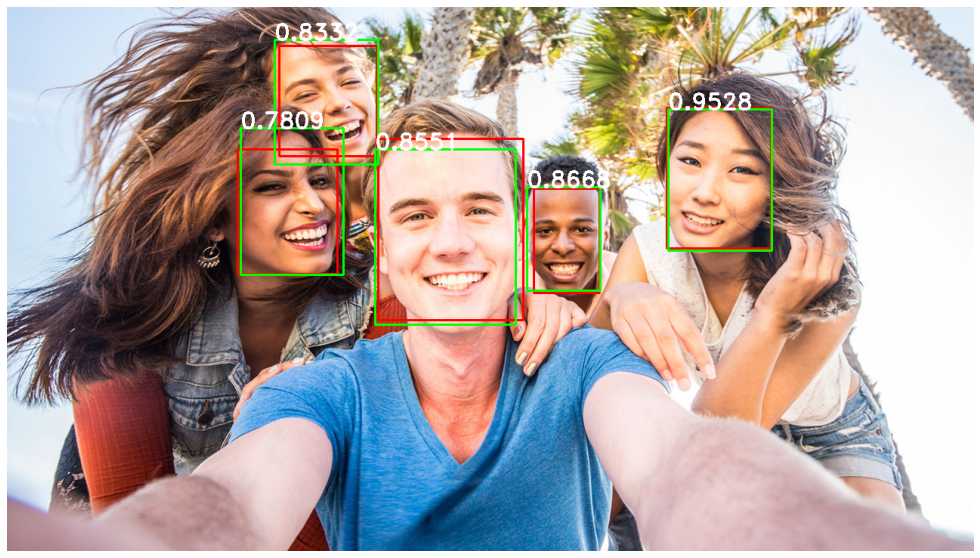

In [20]:
import json
import numpy as np

with open("/content/bbox.json") as json_file:
    data = json.load(json_file)

img = cv2.imread("/content/selfie-group.jpg")

bbox2 = []

for diste in data["annotations"]:
  rect1 = int(diste["bbox"][0])
  rect2 = int(diste["bbox"][1])
  rect3 = int(diste["bbox"][2])
  rect4 = int(diste["bbox"][3])
  arrt = np.array([rect1, rect2, rect3, rect4])
  img = cv2.rectangle(img, (rect1, rect2), (rect3, rect4), red, thickness=2)
  bbox2.append(arrt)

bbox, _, _ = detectFaces(img, from_opencv=True)

iou_metric = []
for x in range(0, len(bbox)):
  deff = iou(bbox[x], bbox2[x])
  iou_metric.append(deff)
  img = cv2.rectangle(img, (bbox[x][0], bbox[x][1]), (bbox[x][2], bbox[x][3]), green, thickness=2)
  img = cv2.putText(img, str('{:.4f}'.format(deff)), (bbox[x][0], bbox[x][1]), font, 1, white, 2)
  print(deff)

RGB_im2 = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
print("Found {} Faces".format(len(bbox2)))
fig = plt.figure(figsize=(18, 10))
plt.imshow(RGB_im2)
plt.axis('off')
plt.show()

**Respuesta:** Se puede apreciar como el valor de la métrica iou está más cercano a 1 cuando los rectángulos están más cerca entre sí. Esto quiere decir que cuando los bounding box etiquetados manualmente se aproximan a los bounding box detectados por el modelo el valor de iou se va acercando a 1.

###Solucion 2

<H3>2) La cara menor</H3>

En esta parte queremos conocer cuál es el menor valor de resolución que tiene RetinaFace. Cargue la fotografía de la selfie más grande del mundo (la misma que ya trabajamos). Extraiga los <i>bounging boxs</i> de la foto, y sus scores. Calcule las distancias de dichas cajas y seleccione las 5 menores. Reporte el tamaño de esas diagonales, el área de la caja y los scores. Utilize la función ```print()``` o ```prettytable()``` para reportar sus resultados.

In [21]:
from math import sqrt
from prettytable import PrettyTable

class Punto:
  def __init__(self, x, y):
    self.x = x
    self.y = y

def calcular_distancia(p1, p2):
  dist = sqrt((p1.x - p2.x)**2 + (p1.y - p2.y)**2)
  return dist

def orderByArea(elem):
    return elem[0]
def orderByDiagonal(elem):
    return elem[1]
def orderByScore(elem):
    return elem[2]

In [22]:
img = cv2.imread("worlds-largest-selfie.jpg")

bbox, landmarks, scores = detectFaces(img, from_opencv=True)

values = []
for (rect, score) in zip(bbox, scores):
  punto1 = Punto(rect[0], rect[1])
  punto2 = Punto(rect[2], rect[3])
  distancia = calcular_distancia(punto1, punto2)
  ancho = rect[2]-rect[0]
  alto = rect[3]-rect[1]
  area = alto * ancho
  values.append([area,distancia,score,rect])

values.sort(key=orderByDiagonal, reverse=False)

+------+-----------+------+--------+
| BBOX | Distancia | Area | Score  |
+------+-----------+------+--------+
|  1   |  16.9706  | 144  | 0.9794 |
|  2   |  17.2047  | 140  | 0.7720 |
|  3   |  17.6918  | 156  | 0.9880 |
|  4   |  17.6918  | 156  | 0.9692 |
|  5   |  17.6918  | 156  | 0.5497 |
+------+-----------+------+--------+


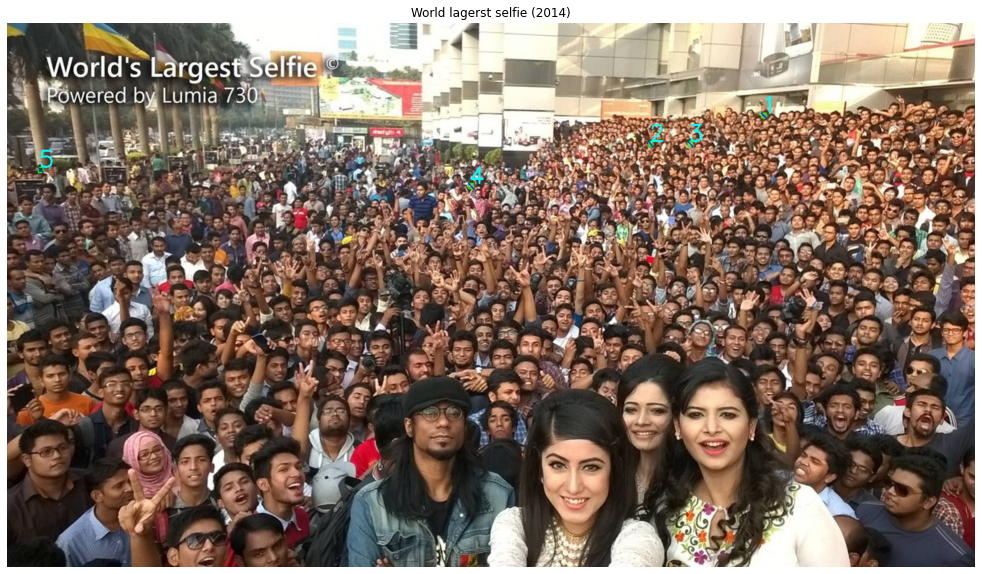

In [23]:
labels = ['BBOX', 'Distancia', 'Area', 'Score']    
table = PrettyTable()

table.field_names = labels
for id in range(0, 5):    
    table_row = [id+1]
    area = values[id][0]
    distancia = values[id][1]
    score = values[id][2]
    rect = values[id][3]
    table_row.append('{:.4f}'.format(distancia))
    table_row.append('{:.0f}'.format(area))    
    table_row.append('{:.4f}'.format(score[0]))
    table.add_row(table_row)
    img = cv2.rectangle(img, (rect[0],rect[1]), (rect[2], rect[3]), green, thickness=2)
    img = cv2.line(img, (rect[0], rect[1]), (rect[2], rect[3]), blue, thickness=2)
    img = cv2.putText(img, str(id+1), (rect[0], rect[1]), font, 2, sky, 2)

print(table)

RGB_im = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
fig = plt.figure(figsize=(18, 10))
plt.imshow(RGB_im)
plt.axis('off')
plt.title('World lagerst selfie (2014)')
plt.show()

###Solucion 3

<H3>3) Difuminado selectivo de rostro</H3>


Vamos a intentar censurar un video. En la serie The Big Bang Theory hay un capítulo de la sexta temporada en el que las chicas quieren ir a Las Vegas y su viaje se arruina. Al mismo tiempo los chicos se quedan a jugar Dungeons and Dragons. Con un propósito educativo vamos a difuminar las caras de los protagonistas Jim Parsons y Jonny Galeki. <br>
Abajo se presenta un código para leer el video utilizando <i>OpenCv</i> y generar un video secundario. Tanto el video como las fotos de referencia de los actores están incluidos en el archivo que se descarga con ```gdown``` al principio del práctico (ver primera celda). Como el video es de alta resolución utiliza mucha memoria RAM, por eso solamente van a procesar los cuadros del 2000 al 3000, como aparece en los códigos provistos.<br>
Usted debe cargar los embeddings de referencia utilizando </i>RetinaFace<i> y <i>Facenet<i>. <br>
Con un propósito educativo vamos a suponer que las chicas no desean aparecer en el video y les piden a usted que difume sus rostros. Por otro lados los chicos quieren tener un registro de su juego pues lo han pasado muy bien. Para ayudarles con la tarea cada actor les ha facilitado una fotografía en lo mejor de sus momentos.<br>
Lo que usted debe hacer es cargar todas las fotos (ya incluidos en el archivo descargado con los ejemplos), capturar los embbedings de referencia e identificar correctamente a los actores para la difuminación de su rostro. Para difuminar un rostro basta con recortarlo disminuirlo a un décimo de su tamaño y devolverlo a su tamaño original, la pérdida de datos por la compresión hace el truco. Puede utilizar la función ```cv2.resize()```.<br>
El resultado de esta parte es un video, el cual puede entregar como un link a youtube para que el ayudante lo pueda revisar.

El video a difuminar es el que puede ver a continuación:

In [25]:
from IPython.display import HTML
from base64 import b64encode
mp4 = open('the-girls-play-dd.mp4','rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()

In [26]:
HTML("""
<video width=400 controls>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)

Johnny Galecki


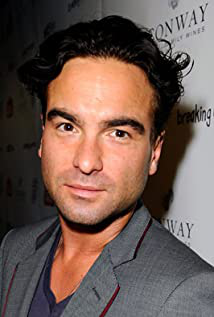



Jim Parsons


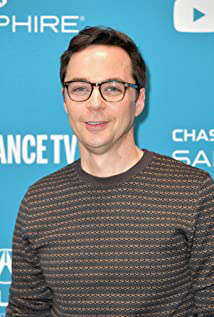



Kaley Cuoco


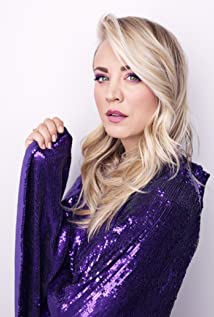



Simon Helberg


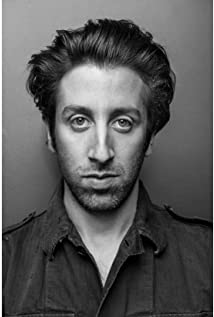



Kunal Nayyar


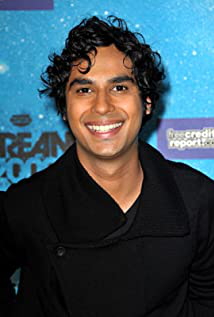



Melissa Rauch


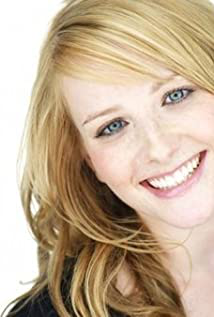



Mayim Bialik


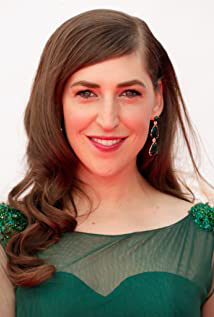

<Figure size 1382.4x468 with 0 Axes>

In [27]:
from PIL import Image
cast = ['Johnny Galecki', 'Jim Parsons', 'Kaley Cuoco', 'Simon Helberg', 'Kunal Nayyar', 'Melissa Rauch', 'Mayim Bialik']
control_imgs = []
control_embd = []
fig = plt.figure(figsize=(19.2,6.5))
for (i, actor) in enumerate(cast):
  # Agregue aquí sus códigos para cargar los embeddings de referencia y 
  # despliegue cada una de las imágenes de los actores. 
  img = Image.open(actor + '.jpg')  
  print(actor)
  display(img)  
  print("")
  print("")
  img_cropped = mtcnn(img)
  img_embedding = facenet(img_cropped.unsqueeze(0))
  img_embedding = img_embedding.view(1, -1).squeeze(0)
  img_embedding = img_embedding.cpu().detach().numpy()
  control_embd.append(img_embedding / np.linalg.norm(img_embedding)) #guardamos los vectores normalizados
  control_imgs.append(actor)

Entonces, procedemos a crear el video con la censura adecuada.

In [28]:
def anonymize_face_pixelate(image, blocks=3):
	(h, w) = image.shape[:2]
	xSteps = np.linspace(0, w, blocks + 1, dtype="int")
	ySteps = np.linspace(0, h, blocks + 1, dtype="int")
	for i in range(1, len(ySteps)):
		for j in range(1, len(xSteps)):
			startX = xSteps[j - 1]
			startY = ySteps[i - 1]
			endX = xSteps[j]
			endY = ySteps[i]
			roi = image[startY:endY, startX:endX]
			(B, G, R) = [int(x) for x in cv2.mean(roi)[:3]]
			cv2.rectangle(image, (startX, startY), (endX, endY),
				(B, G, R), -1)
	return image

In [36]:
import cv2
video = cv2.VideoCapture("the-girls-play-dd.mp4")
fps = round(video.get(cv2.CAP_PROP_FPS))
totalFrames = round(video.get(cv2.CAP_PROP_FRAME_COUNT))
target = [0, 1] #Id de Johnny Galecki y Jim Parsons en las etiquetas
scale_percent = 10
threshold = 0.4

img_array = []
for f in range(0, totalFrames):
    ret, frame = video.read()
    if f < 2000 or f > 3000: #se les pide que iteren únicamente entre estos cuadros por lo que se ignora el resto
        continue    
    # Agregue sus códigos de detección de rostros, cálculo de embeddings de reconocimiento
    # identificación de los objetivos y blur de los recuadros seleccionados
    bboxs, landmarks, scores = detectFaces(frame, from_opencv=True)
    aux = bboxs[0]
    if aux is not None: 
      candidates = {}
      for bbox in bboxs:
        crop = frame[bbox[1]:bbox[3], bbox[0]:bbox[2]] #Recortamos directamente con lo obtenido en RetinaFace
        if crop.size <= 470:
          continue        
        aligned = mtcnn(Image.fromarray(cv2.cvtColor(crop, cv2.COLOR_BGR2RGB)))
        if aligned == None:
          continue
        img_embedding = facenet(aligned.unsqueeze(0)) #Obtenemos el vector de identificación de facenet
        img_embedding = img_embedding.view(1, -1).squeeze(0)
        img_embedding = img_embedding.cpu().detach().numpy()
        compare = img_embedding / np.linalg.norm(img_embedding)    
        for num in target:
          similitud = compare.dot(control_embd[num])
          if similitud > threshold: 
            candidates[cast[num]] = bbox
            
      if candidates: 
        for nombre in candidates:
          bbox = candidates[nombre]
          # frame = cv2.rectangle(frame, (bbox[0], bbox[1]), (bbox[2], bbox[3]), green, thickness=2)
          # frame = cv2.putText(frame,nombre, (bbox[0], bbox[1]), font, 2, sky, 2) 
          face = frame[bbox[1]:bbox[3], bbox[0]:bbox[2]] 
          face = anonymize_face_pixelate(face, blocks=scale_percent) #Pixeleado de rostro
          frame[bbox[1]:bbox[3], bbox[0]:bbox[2]] = face
    #
    #
    #

    img_array.append(frame)
    msj = "Working video {:.2f}% complete".format((f-2000)/1000*100)
    for i in range(len(msj)):
        sys.stdout.write('\r')
    sys.stdout.write(msj)

#Códigos para generar el video censurado, no los modifique, es normal que la salida no contemple sonido.
height, width, layers = frame.shape
size = (width, height)
video.release()

out = cv2.VideoWriter('video_output.mp4',cv2.VideoWriter_fourcc(*'DIVX'), fps, size)
 
for img in img_array:
    out.write(img)
out.release()

Working video 100.00% complete

In [37]:
#Descargue el video para ver sus resultados.
from google.colab import files
files.download('video_output.mp4')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

**Url del video:** https://youtu.be/ZCjFafDgmow

<H3>Bibliografía</H3><p>
Artículos científicos
<ul>

<li>Deng, J., Guo, J., Xue, N., & Zafeiriou, S. (2019). Arcface: Additive angular margin loss for deep face recognition. In Proceedings of the IEEE Conference on Computer Vision and Pattern Recognition (pp. 4690-4699).</li>
<li>Schroff, F., Kalenichenko, D., & Philbin, J. (2015). Facenet: A unified embedding for face recognition and clustering. In Proceedings of the IEEE conference on computer vision and pattern recognition (pp. 815-823).</li>
<li>Wang, H., Wang, Y., Zhou, Z., Ji, X., Gong, D., Zhou, J., ... & Liu, W. (2018). Cosface: Large margin cosine loss for deep face recognition. In Proceedings of the IEEE Conference on Computer Vision and Pattern Recognition (pp. 5265-5274).</li>
</ul>
<br>
<H5>Sitios web para etiquetar</H5>

<ul>
<li> CVat. https://github.com/openvinotoolkit/cvat</li>
<li> LabelMe. http://labelme2.csail.mit.edu/Release3.0/index.php. https://github.com/wkentaro/labelme </li>
<li> Lionbridge. https://lionbridge.ai/ </li>
<li> VoTT. https://github.com/microsoft/VoTT </li>
<li> Light Tag. https://www.lighttag.io/</li>
<li> Playment. https://playment.io/ </li>
<li> TagTog. https://www.tagtog.net/</li>
<li> MedTagger. https://github.com/medtagger/MedTagger</li>
<li> Pixie.  https://github.com/buni-rock/Pixie</li>
<li> The Ultimate Guide to Data Labeling for Machine Learning. No es una herramienta, sino una guía para anotar imágenes. https://www.cloudfactory.com/data-labeling-guide </li>
</ul> 

